## Loading Packages

In [27]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import igraph as ig
import leidenalg
from scipy.stats import gaussian_kde
import umap
import os
import math
import fcsparser

# -------------------------------------------- #

import cellCnn
from cellCnn.utils import loadFCS, ftrans, mkdir_p, get_items
from cellCnn.model import CellCnn
from cellCnn.plotting import plot_results


## Define WDIR and Paths

In [9]:
# Define input and output directories
WDIR = os.getcwd()
DATA_PATH = os.path.join(WDIR, 'data')
FCS_DATA_PATH = os.path.join(DATA_PATH, 'gated_NK')
DATA_LABELS_PATH = os.path.join(DATA_PATH, 'NK_fcs_samples_with_labels.csv')
MARKERS_PATH = os.path.join(DATA_PATH, 'NK_markers.csv')
OUTPUT_PATH = os.path.join(WDIR, 'output')
PLOT_PATH = os.path.join(OUTPUT_PATH, 'plots')

## Load Data

In [ ]:
# Load fcs file labels
labels = pd.read_csv(DATA_LABELS_PATH)

markers = ['CD3', 'CD27', 'CD19', 'CD4', 'CD8', 'CD57', '2DL1-S1', 'TRAIL', '2DL2-L3-S2',
           'CD16', 'CD10', '3DL1-S1', 'CD117', '2DS4', 'ILT2-CD85j', 'NKp46', 'NKG2D',
           'NKG2C', '2B4', 'CD33', 'CD11b', 'NKp30', 'CD122', '3DL1', 'NKp44', 'CD127', '2DL1',
           'CD94', 'CD34', 'CCR7', '2DL3', 'NKG2A', 'HLA-DR', '2DL4', 'CD56', '2DL5', 'CD25']
    
# Load FCS data and add labels to the data for every file from the labels file 
def load_fcs_data(fcs_folder):
    data_list = []
    for filename in os.listdir(fcs_folder):
        if filename.endswith(".fcs"):
            path = os.path.join(fcs_folder, filename)
            meta, data = fcsparser.parse(path)
            data.head()
            data['filename'] = filename
            data['label'] = labels[labels['fcs_filename'] == filename]['label'].values[0]
            data_list.append(data)
    return pd.concat(data_list)

data = load_fcs_data(FCS_DATA_PATH)

## Subsampling and Scaling

In [12]:
def subsample_scale_data(data, size=10000):
    subsample = data.sample(n=size, random_state=42, ignore_index=True)
    subsample_labels = subsample['label']
    markers = ['CD3', 'CD27', 'CD19', 'CD4', 'CD8', 'CD57', '2DL1-S1', 'TRAIL', '2DL2-L3-S2',
           'CD16', 'CD10', '3DL1-S1', 'CD117', '2DS4', 'ILT2-CD85j', 'NKp46', 'NKG2D',
           'NKG2C', '2B4', 'CD33', 'CD11b', 'NKp30', 'CD122', '3DL1', 'NKp44', 'CD127', '2DL1',
           'CD94', 'CD34', 'CCR7', '2DL3', 'NKG2A', 'HLA-DR', '2DL4', 'CD56', '2DL5', 'CD25']
    
    subsample = subsample[markers]

    scaler = StandardScaler()
    subsample_scaled = scaler.fit_transform(subsample)
    

    return subsample_scaled, subsample_labels

In [13]:
# Random sampling without replacement
X_10k, y_10k = subsample_scale_data(data, size=10000)
X_20k, y_20k = subsample_scale_data(data, size=20000)
X_50k, y_50k = subsample_scale_data(data, size=50000)

## EDA

In [29]:
# Plot histograms for selected markers
#select_markers = ['CD3', 'CD27', 'CD19']

def _save_hist_plots(data : pd.DataFrame, select_markers, markers_per_row=5, cap_outliers=True):
    
    num_markers = len(select_markers)
    rows = math.ceil(num_markers / markers_per_row)  # Calculate the number of rows needed
    cols = markers_per_row  # Set the number of columns (5 markers per row)
    
    # Create a figure large enough to fit all plots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3), constrained_layout=True)
    
    # Flatten axes to easily iterate
    axes = axes.flatten() if rows > 1 else [axes]
    
    # Iterate through each marker
    for idx, marker in enumerate(select_markers):
        ax = axes[idx]
        
        # Handle outliers by capping extreme values
        if cap_outliers:
            data_capped = np.clip(data[marker], a_min=np.percentile(data[marker], 1), a_max=np.percentile(data[marker], 99))
        else:
            data_capped = data[marker]
        
        # Log-transform the intensity values
        data_log = np.log1p(data_capped)
        
        # Plot histogram with KDE
        sns.histplot(data_log, bins=70, kde=True, kde_kws={'bw_adjust': 0.8}, color='blue', alpha=0.3, ax=ax)
        
        # Apply log scale to the y-axis for frequency
        ax.set_yscale('log')
        ax.set_xlim(-2, 2)
        
        # Add statistical annotation (mean)
        mean_intensity = np.mean(data_log)
        ax.axvline(mean_intensity, color='red', linestyle='--')
        ax.text(mean_intensity, ax.get_ylim()[1] * 0.9, f'Mean: {mean_intensity:.2f}', color='red')
        
        # Set the title
        ax.set_title(marker)
        ax.set_xlabel('Log(Intensity)')
        ax.set_ylabel('Log(Frequency)')
    
    # Remove any empty subplots if there are fewer markers than grid spots
    for ax in axes[len(select_markers):]:
        ax.axis('off')

    # Save the entire figure to a single file
    plot_file = os.path.join(PLOT_PATH, f'EDA_marker_expression_distribution_{int(len(data)/1000)}k.png')
    fig.savefig(plot_file, dpi=300)
    plt.close(fig)  # Close the figure to free memory

In [30]:
_save_hist_plots(pd.DataFrame(X_10k, columns=markers), markers)
_save_hist_plots(pd.DataFrame(X_20k, columns=markers), markers)
_save_hist_plots(pd.DataFrame(X_50k, columns=markers), markers)

In [28]:
def plot_hist(data, select_markers, markers_per_grid=10, cap_outliers=True):
    num_grids = math.ceil(len(select_markers) / markers_per_grid)
    
    for i in range(num_grids):
        # Get the subset of markers
        markers_subset = select_markers[i * markers_per_grid:(i + 1) * markers_per_grid]
        
        # Handle outliers by capping extreme values
        if cap_outliers:
            data_capped = data[markers_subset].apply(lambda x: np.clip(x, a_min=np.percentile(x, 1), a_max=np.percentile(x, 99)))
        else:
            data_capped = data[markers_subset]
        
        # Log-transform the intensity values
        data_log = data_capped.apply(np.log1p)  # log1p to safely handle zeros
        data_long = data_log.melt(var_name='Marker', value_name='Log Intensity')
        
        # Create the FacetGrid with log-log scale and dynamic binning
        g = sns.FacetGrid(data_long, col='Marker', col_wrap=5, height=3, aspect=1.2, palette="husl")
        g.map(sns.histplot, 'Log Intensity', bins=70, kde=True, kde_kws={'bw_adjust': 0.8}, color='blue', alpha=0.3)
        
        # Apply log scale to the y-axis for frequency
        for ax, marker in zip(g.axes.flat, markers_subset):
            ax.set_yscale('log')
            # Set x-axis limits to focus on meaningful intensity ranges
            ax.set_xlim(-2, 2)
            
            # Add statistical annotation (mean)
            mean_intensity = np.mean(data[marker].apply(np.log1p))
            ax.axvline(mean_intensity, color='red', linestyle='--')
            ax.text(mean_intensity, ax.get_ylim()[1]*0.9, f'Mean: {mean_intensity:.2f}', color='red')
        
        # Set titles and labels
        g.set_titles('{col_name}')
        g.set_axis_labels('Log(Intensity)', 'Log(Frequency)')
        
        # Tight layout for better spacing
        plt.tight_layout()
        plt.show()

## Dimensionality Reduction

In [95]:
def plot_density(embedding, method):
    # Extract the components
    x = embedding[:, 0]
    y = embedding[:, 1]

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort points by density for better visualization
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    plt.figure(figsize=(10, 6))

    # Scatter plot for the points
    scatter = plt.scatter(x, y, c=z, cmap='viridis', s=5)

    # Add KDE contours
    sns.kdeplot(x=x, y=y, levels=5, color='black', linewidths=1, fill=True, alpha=0.2, bw_adjust=0.7)

    # Add colorbar
    plt.colorbar(scatter, label='Density')

    plt.title(f'{method} Plot with Density Contours on {int(len(embedding)/1000)}k Data Points ')
    plt.xlabel(f'{method} Component 1')
    plt.ylabel(f'{method} Component 2')
    plt_name = os.path.join(PLOT_PATH, f'{method}_density_contours_plot_{int(len(embedding)/1000)}k.png')
    plt.savefig(plt_name)
    plt.show()

### PCA

In [40]:
def apply_pca(data, n_components=10):
    pca = PCA(n_components=n_components, random_state=42)
    pca_result = pca.fit_transform(data)
    return pca_result

In [41]:
## PCA with 10 components
X_10k_pca = apply_pca(X_10k)
X_20k_pca = apply_pca(X_20k)
X_50k_pca = apply_pca(X_50k)

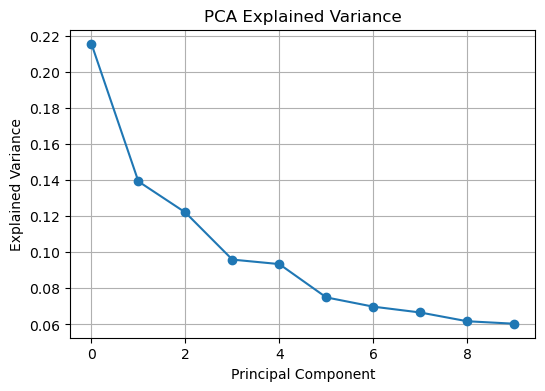

In [44]:
## plot pca variance explained by each component 
def plot_pca_variance(data, n_components=10):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(data)

    plt.figure(figsize=(6, 4))
    plt.plot(pca.explained_variance_ratio_, marker='o')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True)
    plt.show()

plot_pca_variance(X_10k_pca, n_components=10)

/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


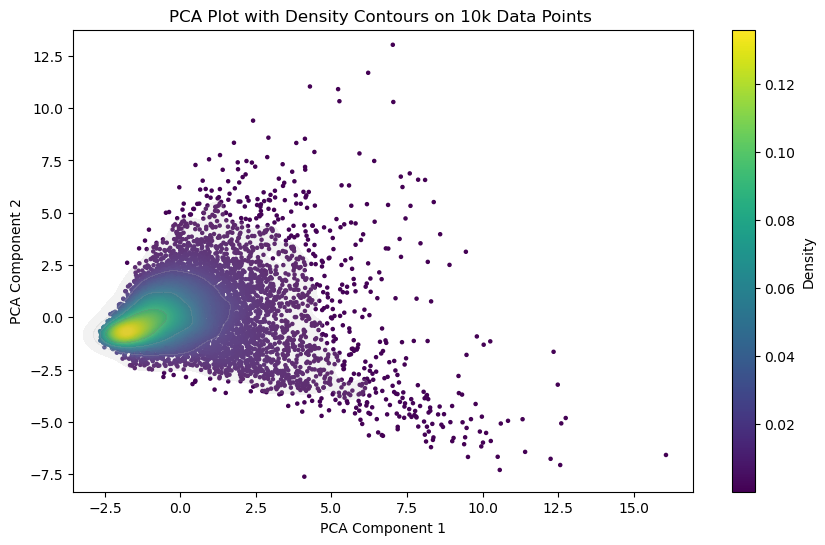

In [96]:
plot_density(embedding=X_10k_pca, method="PCA")

/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


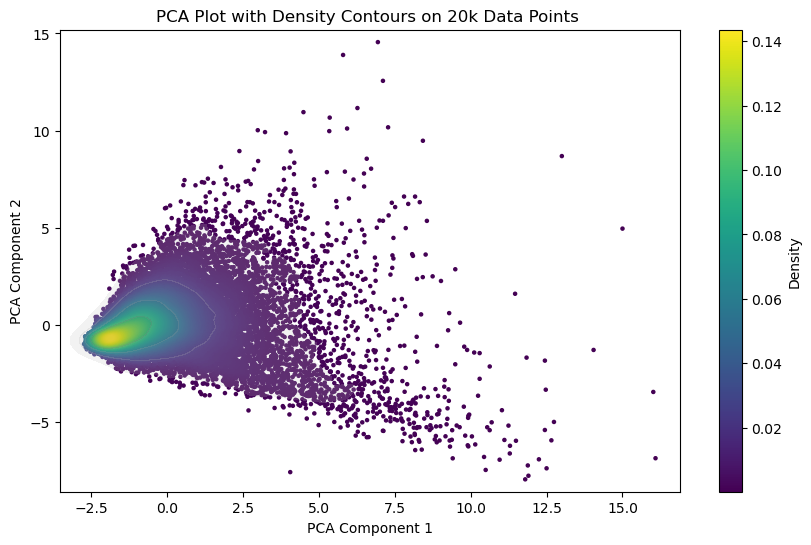

In [97]:
plot_density(embedding=X_20k_pca, method="PCA")

/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


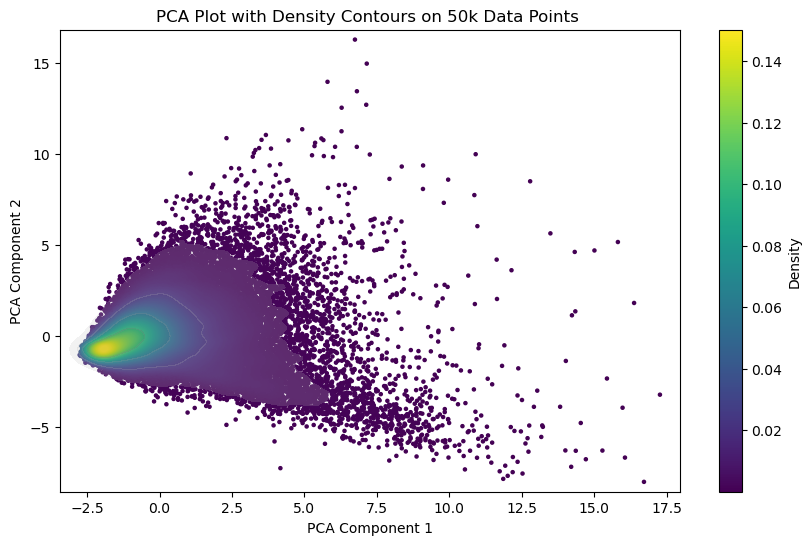

In [98]:
plot_density(embedding=X_50k_pca, method="PCA")

### t-SNE

In [99]:
def apply_tsne(data, perplexity=30, n_components=2, learning_rate=200, n_iter=1000):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    tsne_result = tsne.fit_transform(data)
    return tsne_result

/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


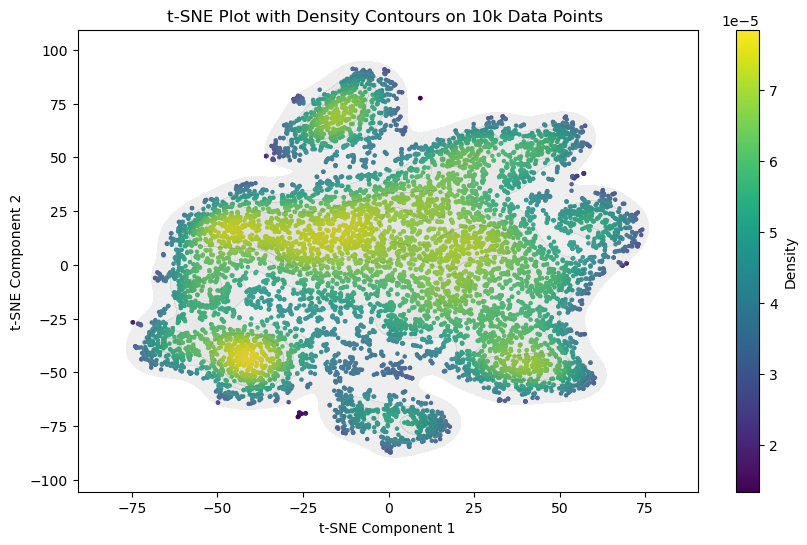

In [100]:
tsne_10k = apply_tsne(X_10k_pca)
plot_density(embedding=tsne_10k, method="t-SNE")

/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


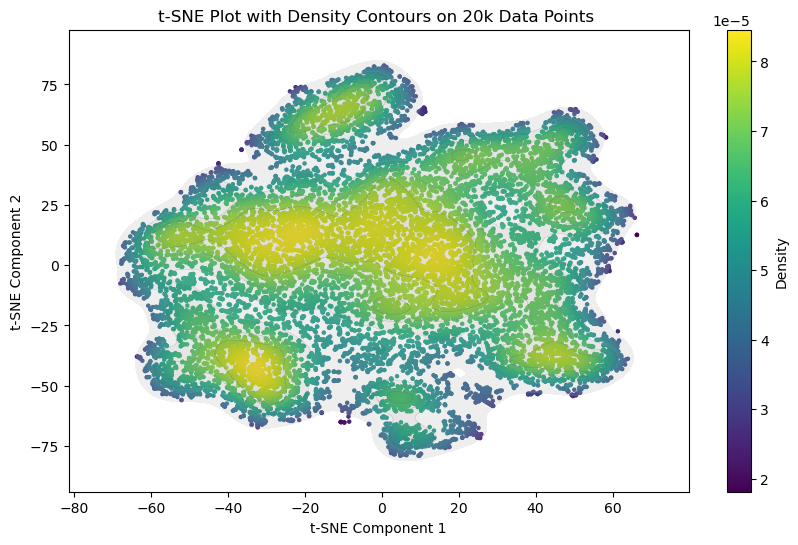

In [101]:
tsne_20k = apply_tsne(X_20k_pca)
plot_density(embedding=tsne_20k, method="t-SNE")

/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


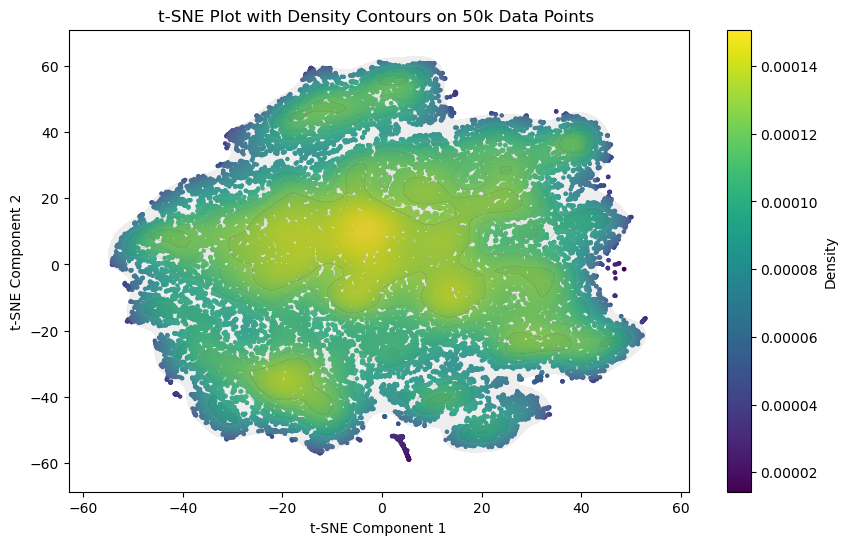

In [102]:
tsne_50k = apply_tsne(X_50k_pca)
plot_density(embedding=tsne_50k, method="t-SNE")

### UMAP

In [103]:
def apply_umap(data, n_neighbors=10, n_components=2, metric='euclidean'):
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, metric=metric)
    umap_result = reducer.fit_transform(data)
    return umap_result
    

/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


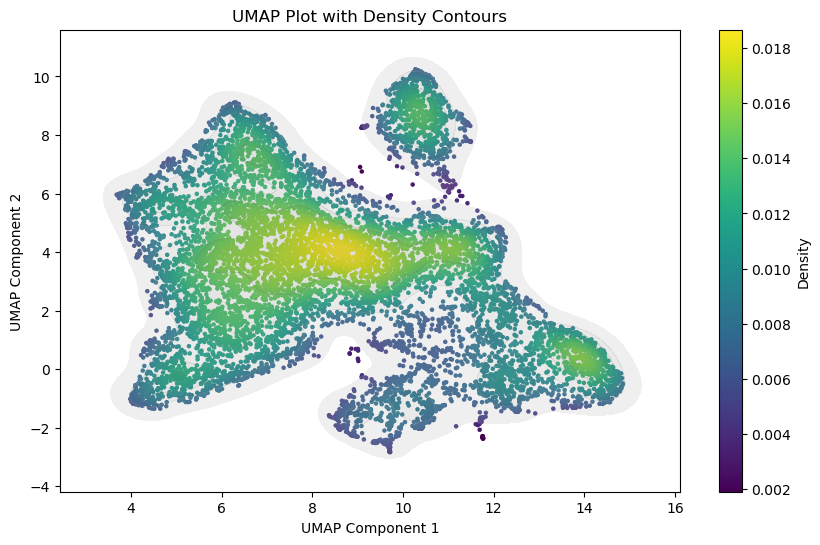

In [57]:
umap_10k = apply_umap(X_10k_pca)
plot_density(embedding=umap_10k, method="UMAP")

/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


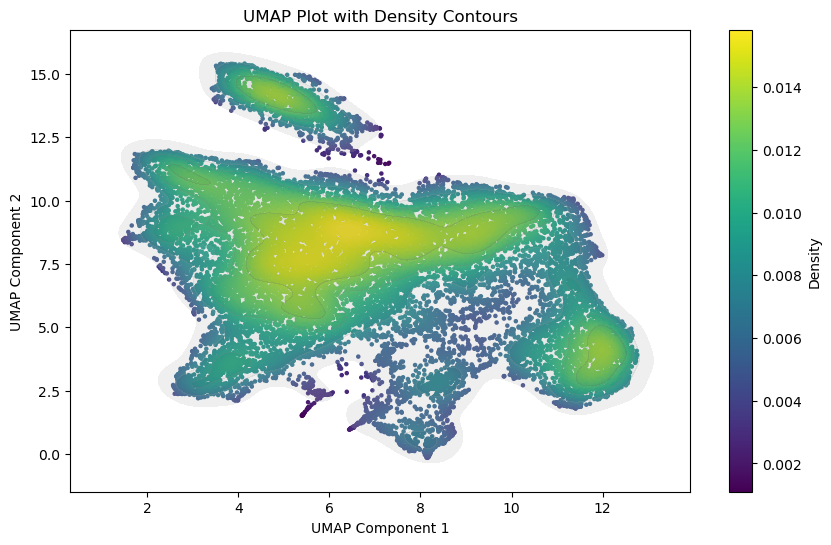

In [77]:
umap_20k = apply_umap(X_20k_pca)
plot_density(embedding=umap_20k, method="UMAP")

/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


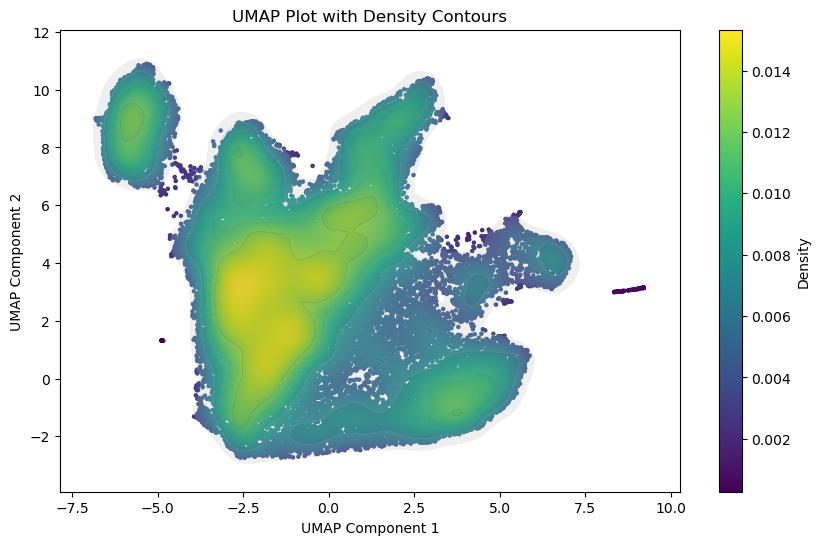

In [78]:
umap_50k = apply_umap(X_50k_pca)
plot_density(embedding=umap_50k, method="UMAP")

## Comparing the Methods

In [103]:
# # Calculate Silhouette Scores for PCA, t-SNE, and UMAP
# def calculate_silhouette(data, labels):
#     return silhouette_score(data, labels)

# # Using PCA, t-SNE, and UMAP results as labels for silhouette score
# pca_silhouette = calculate_silhouette(scaled_data, pca_result[:, 0])
# tsne_silhouette = calculate_silhouette(scaled_data, tsne_result[:, 0])
# umap_silhouette = calculate_silhouette(scaled_data, umap_result[:, 0])

# print(f"Silhouette score for PCA: {pca_silhouette}")
# print(f"Silhouette score for t-SNE: {tsne_silhouette}")
# print(f"Silhouette score for UMAP: {umap_silhouette}")


Silhouette score for PCA: -0.00048676328151486814
Silhouette score for t-SNE: -0.0005632989341393113
Silhouette score for UMAP: -0.0007580032106488943


## Clustering

In [72]:
def plot_clustering(embedding, projection_method, clustering_method, clustering_labels):
    plt.figure(figsize=(10, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=clustering_labels, cmap='tab20', s=5)
    plt.title(f'{clustering_method} Clustering on {projection_method} Projection of {int(len(embedding)/1000)}k Data Points')
    plt.xlabel(f'{projection_method} Component 1')
    plt.ylabel(f'{projection_method} Component 2')
    plt_title = os.path.join(PLOT_PATH, f'{clustering_method}_clustering_on_{projection_method}_{int(len(embedding)/1000)}k.png')
    plt.savefig(plt_title)
    plt.show()

### K-means

In [73]:
def apply_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(data)
    return kmeans_labels


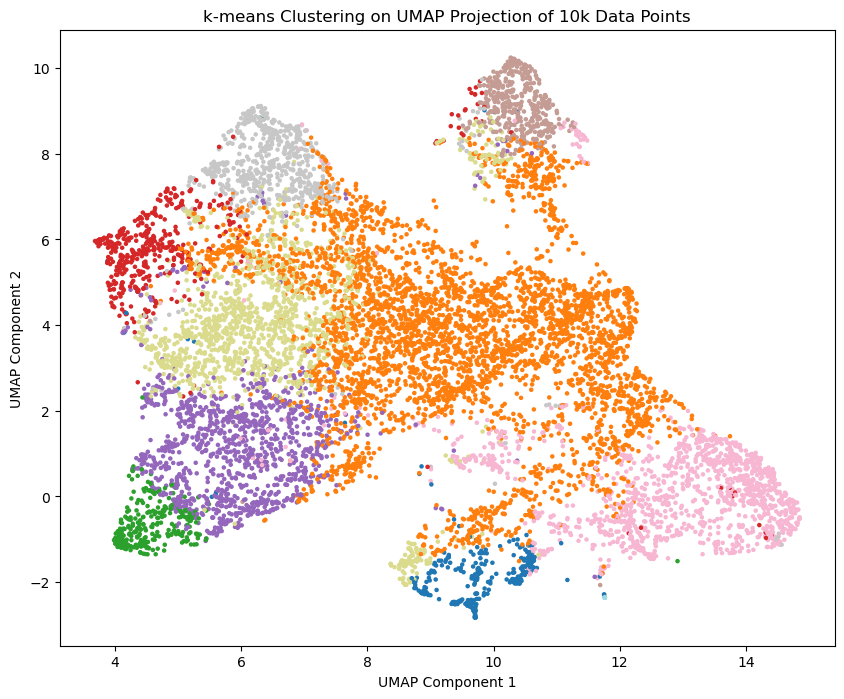

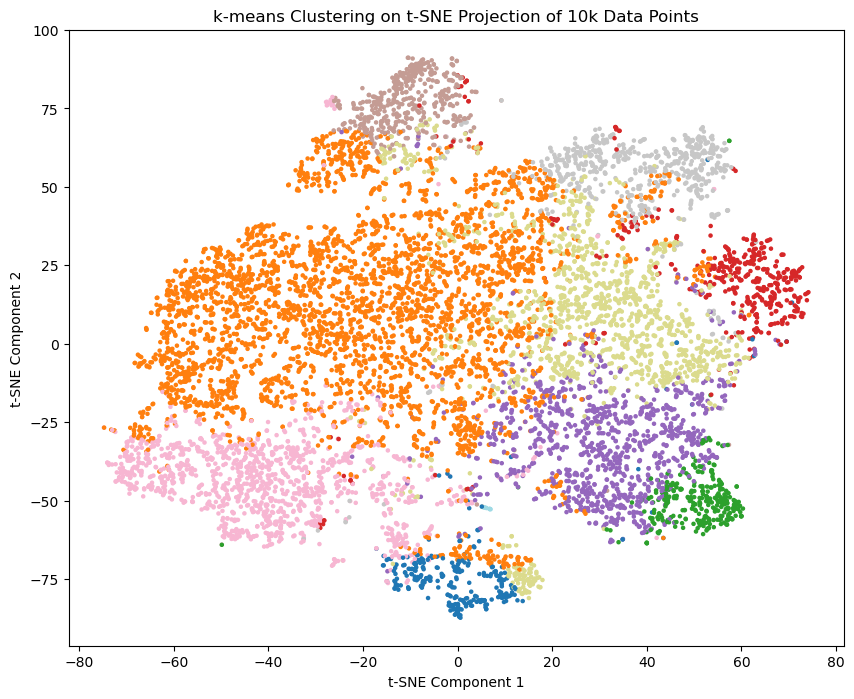

In [104]:
# Apply k-means clustering for 10k samples
kmeans_labels_10k = apply_kmeans(X_10k_pca, n_clusters=10)

plot_clustering(umap_10k, projection_method='UMAP', clustering_method="k-means", clustering_labels=kmeans_labels_10k)
plot_clustering(tsne_10k, projection_method='t-SNE', clustering_method="k-means", clustering_labels=kmeans_labels_10k)

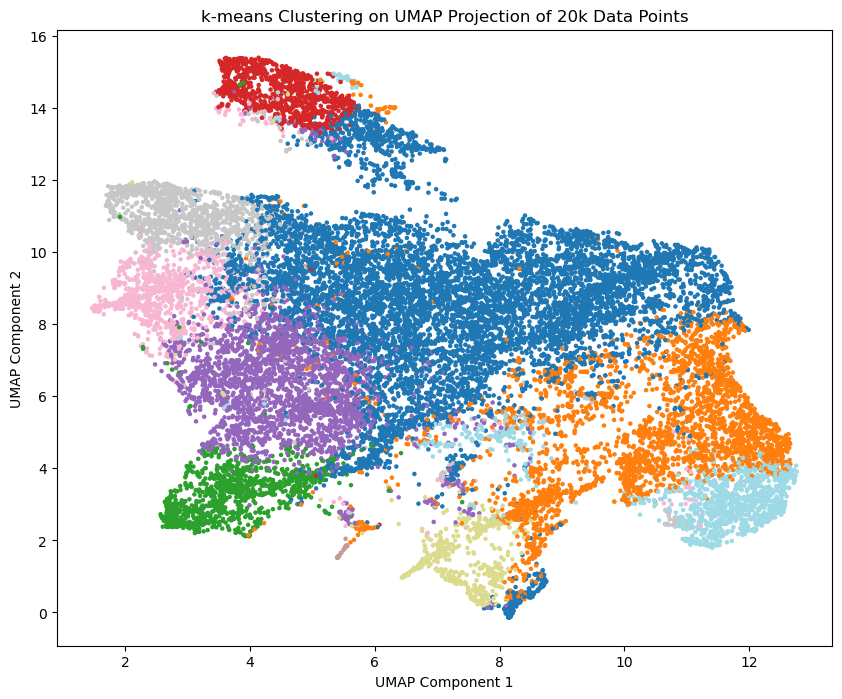

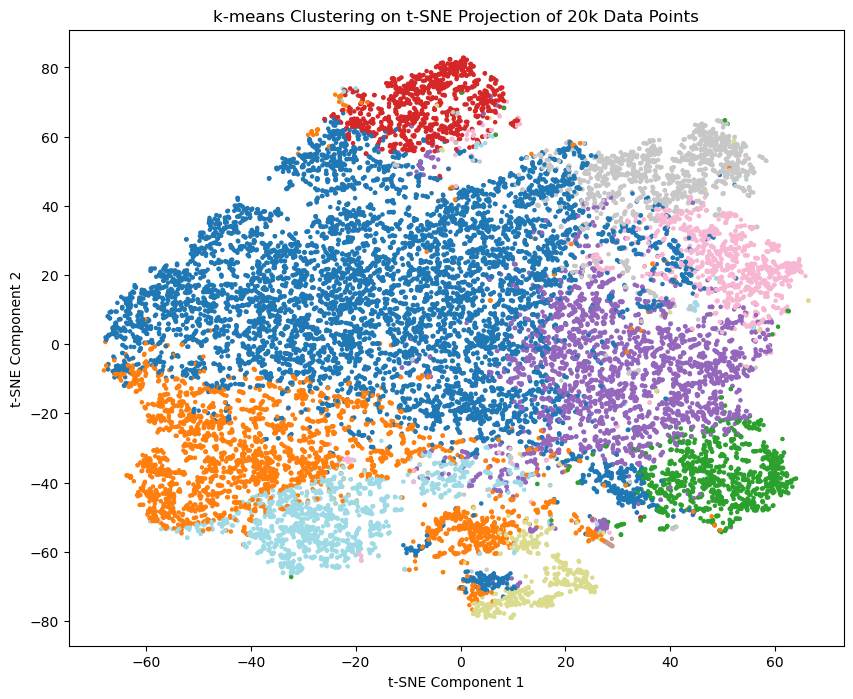

In [105]:
# Apply k-means clustering for 20k samples
kmeans_labels_20k = apply_kmeans(X_20k_pca, n_clusters=10)

plot_clustering(umap_20k, projection_method='UMAP', clustering_method="k-means", clustering_labels=kmeans_labels_20k)
plot_clustering(tsne_20k, projection_method='t-SNE', clustering_method="k-means", clustering_labels=kmeans_labels_20k)

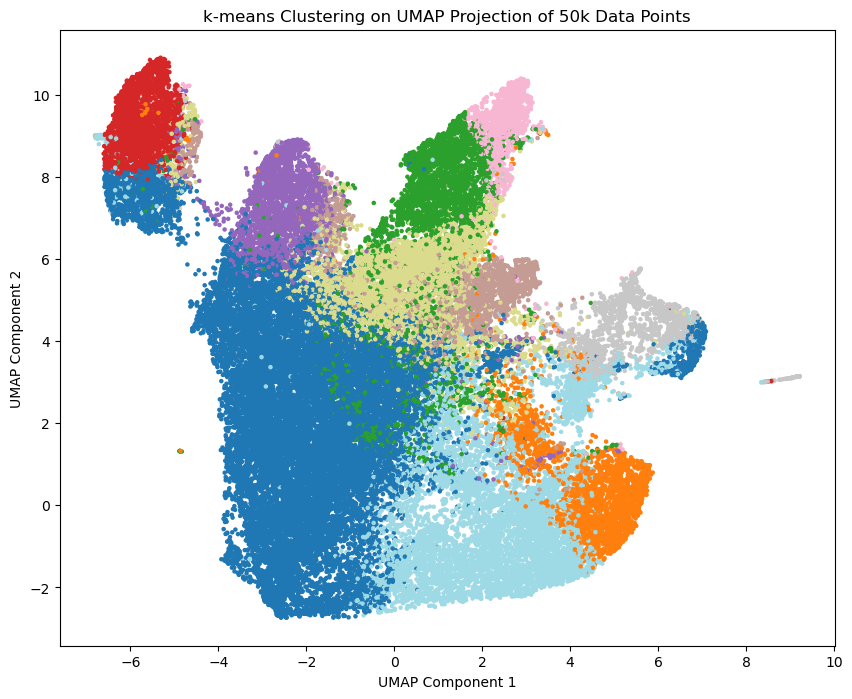

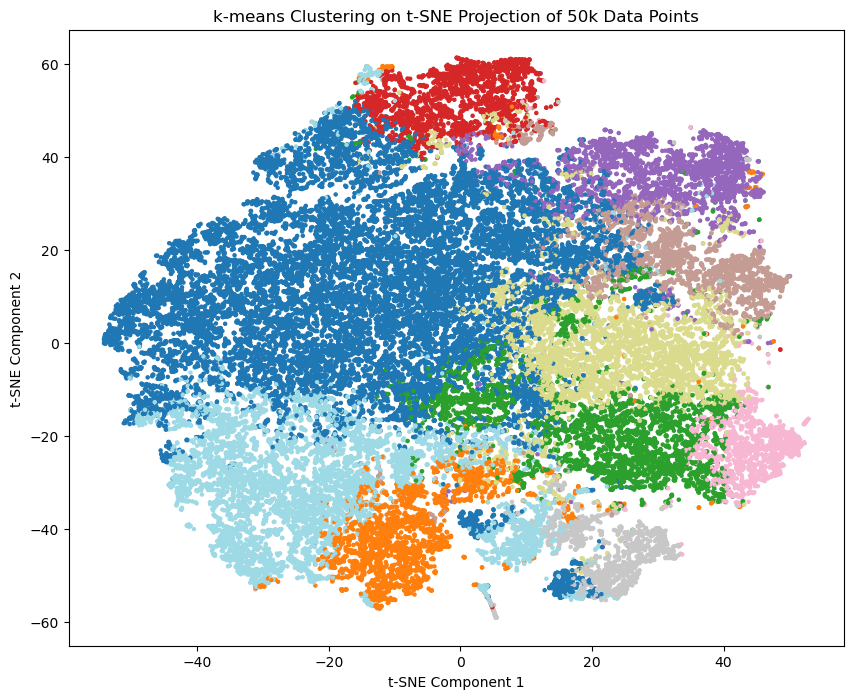

In [106]:
# Apply k-means clustering for 50k samples
kmeans_labels_50k = apply_kmeans(X_50k_pca, n_clusters=10)

plot_clustering(umap_50k, projection_method='UMAP', clustering_method="k-means", clustering_labels=kmeans_labels_50k)
plot_clustering(tsne_50k, projection_method='t-SNE', clustering_method="k-means", clustering_labels=kmeans_labels_50k)

### Hierarchical

In [81]:
from scipy.cluster.hierarchy import linkage, fcluster

def apply_hierarchical(data, n_clusters):
    Z = linkage(data, method='ward')
    hierarchical_labels = fcluster(Z, n_clusters, criterion='maxclust')
    return hierarchical_labels

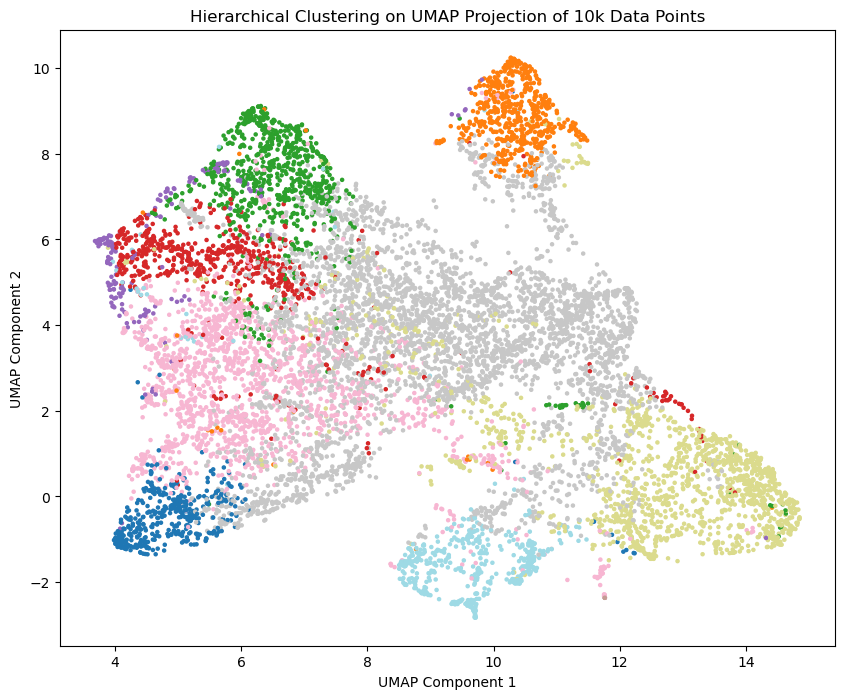

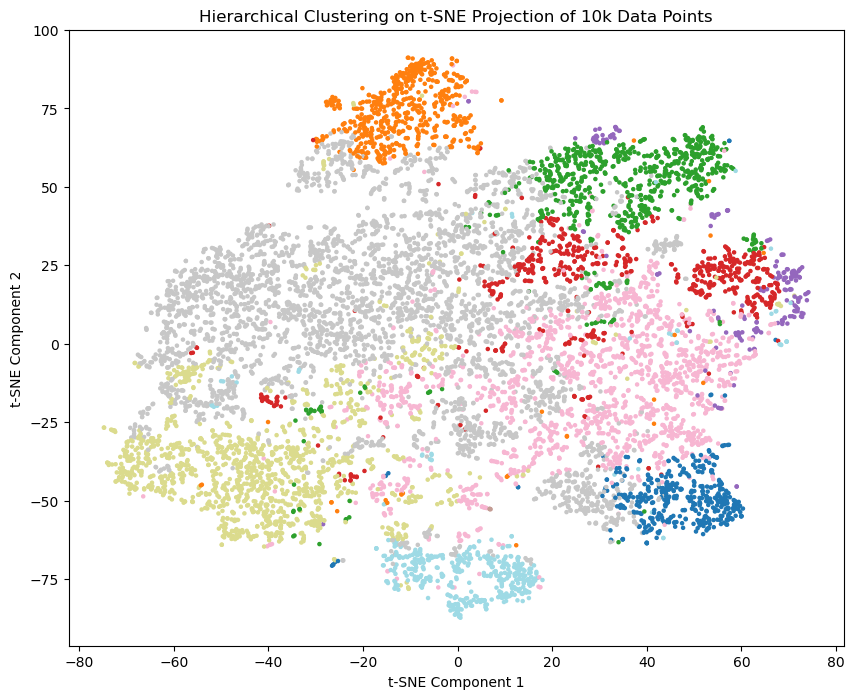

In [107]:
# Apply Hierarchical Clustering for 10k samples
hierarchical_labels_10k = apply_hierarchical(X_10k_pca, n_clusters=10)

plot_clustering(umap_10k, projection_method='UMAP', clustering_method="Hierarchical", clustering_labels=hierarchical_labels_10k)
plot_clustering(tsne_10k, projection_method='t-SNE', clustering_method="Hierarchical", clustering_labels=hierarchical_labels_10k)


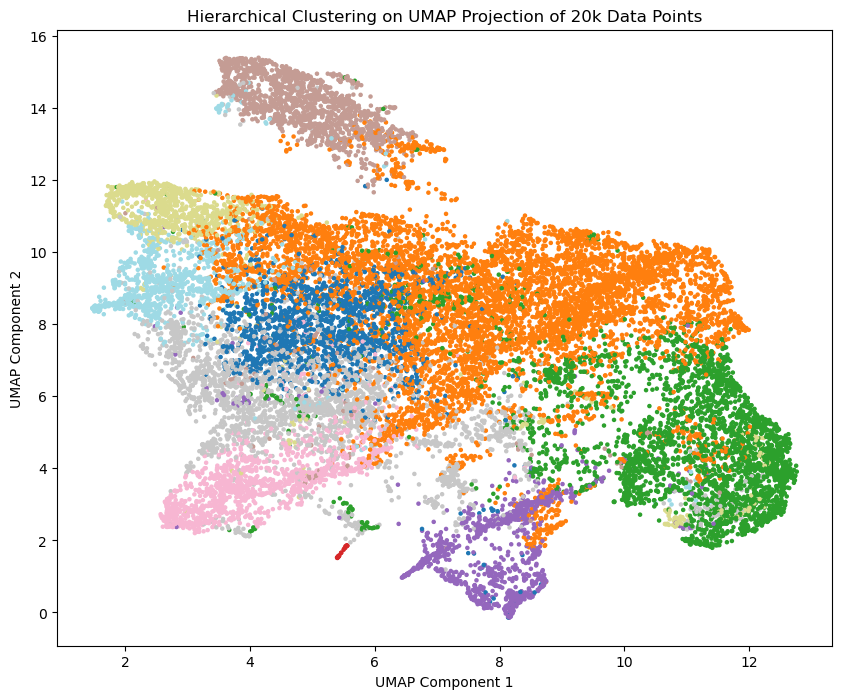

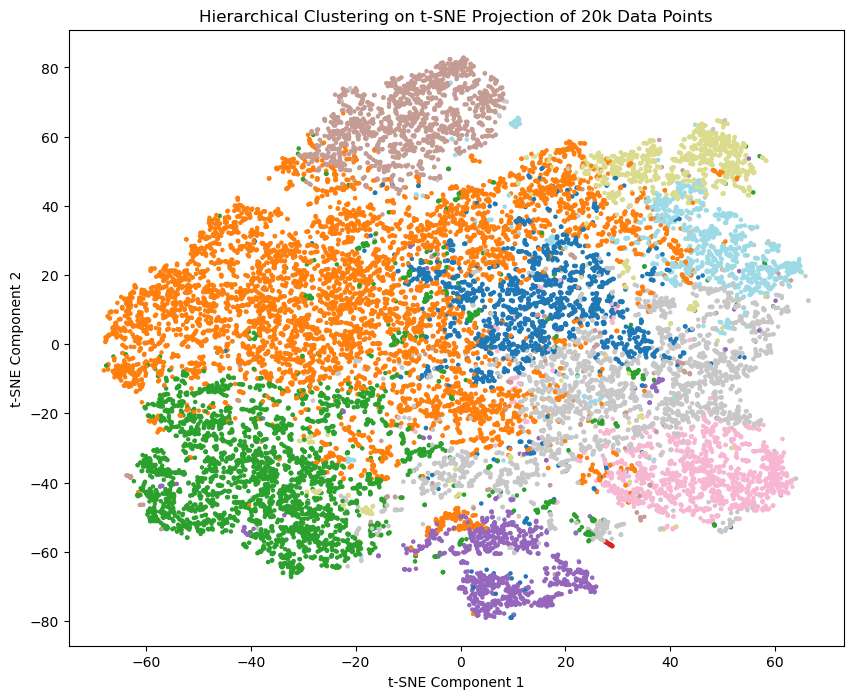

In [108]:
# Apply Hierarchical Clustering for 20k samples
hierarchical_labels_20k = apply_hierarchical(X_20k_pca, n_clusters=10)

plot_clustering(umap_20k, projection_method='UMAP', clustering_method="Hierarchical", clustering_labels=hierarchical_labels_20k)
plot_clustering(tsne_20k, projection_method='t-SNE', clustering_method="Hierarchical", clustering_labels=hierarchical_labels_20k)


In [109]:
# Apply Hierarchical Clustering for 50k samples
hierarchical_labels_50k = apply_hierarchical(X_50k_pca, n_clusters=10)

plot_clustering(umap_50k, projection_method='UMAP', clustering_method="Hierarchical", clustering_labels=hierarchical_labels_50k)
plot_clustering(tsne_50k, projection_method='t-SNE', clustering_method="Hierarchical", clustering_labels=hierarchical_labels_50k)

### Leiden

In [89]:
def apply_leiden(embedding, n_neighbors = 10):
    ## construct k-NN Graph
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(embedding)
    knn_graph = knn.kneighbors_graph(embedding, mode='connectivity')
    
    ## apply leiden on constructed graph
    sources, targets = knn_graph.nonzero()
    edges = list(zip(sources, targets))
    g = ig.Graph(edges=edges, directed=False)
    weights = knn_graph.data
    g.es['weight'] = weights

    partition = leidenalg.find_partition(
        g,
        leidenalg.RBConfigurationVertexPartition,
        weights=g.es['weight'],
        resolution_parameter=0.6
    )
    leiden_labels = np.array(partition.membership)

    return leiden_labels


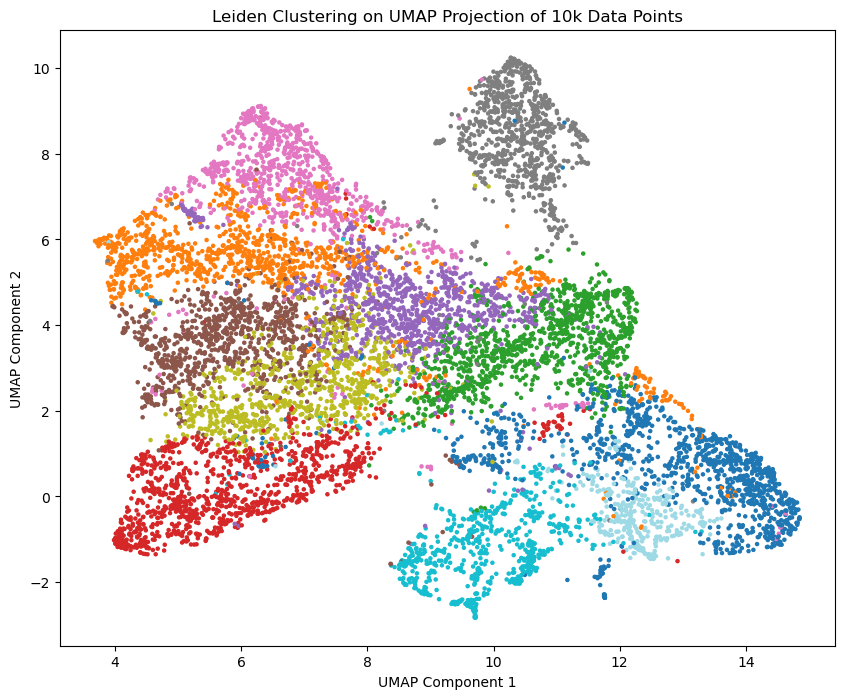

NameError: name 'tsne_10k' is not defined

In [90]:
# Apply Leiden Clustering for 10k Samples 
leiden_labels_10k = apply_leiden(X_10k_pca)

plot_clustering(umap_10k, projection_method='UMAP', clustering_method="Leiden", clustering_labels=leiden_labels_10k)
plot_clustering(tsne_10k, projection_method='t-SNE', clustering_method="Leiden", clustering_labels=leiden_labels_10k)

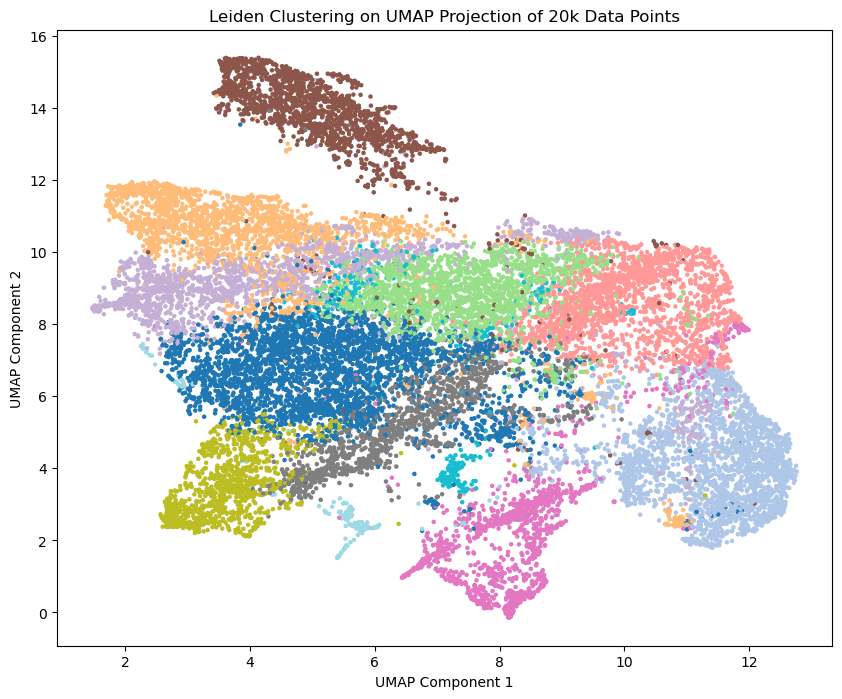

NameError: name 'tsne_20k' is not defined

In [91]:
# Apply Leiden Clustering for 20k Samples 
leiden_labels_20k = apply_leiden(X_20k_pca)

plot_clustering(umap_20k, projection_method='UMAP', clustering_method="Leiden", clustering_labels=leiden_labels_20k)
plot_clustering(tsne_20k, projection_method='t-SNE', clustering_method="Leiden", clustering_labels=leiden_labels_20k)


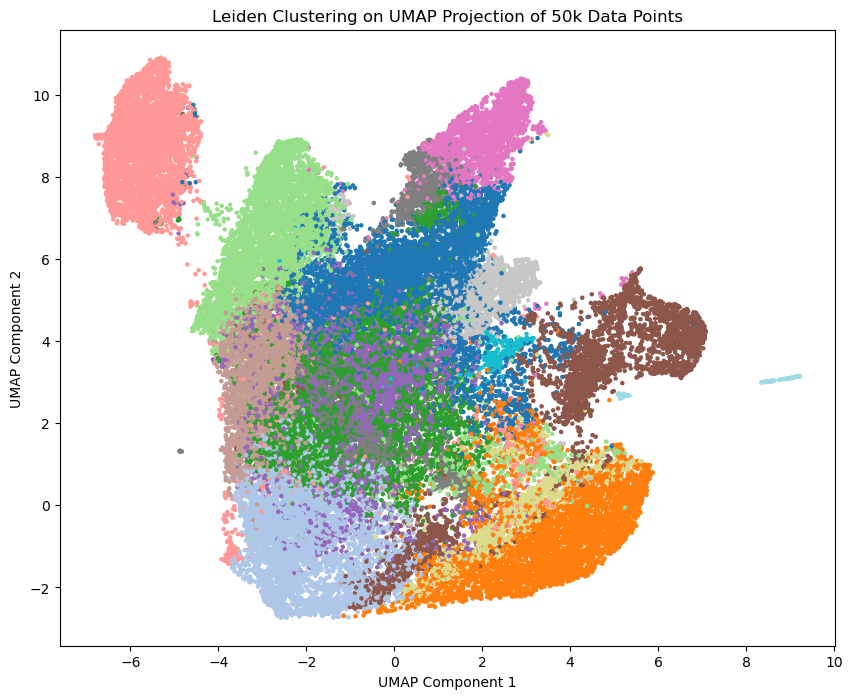

NameError: name 'tsne_50k' is not defined

In [92]:
# Apply Leiden Clustering for 50k Samples 
leiden_labels_50k = apply_leiden(X_50k_pca)

plot_clustering(umap_50k, projection_method='UMAP', clustering_method="Leiden", clustering_labels=leiden_labels_50k)
plot_clustering(tsne_50k, projection_method='t-SNE', clustering_method="Leiden", clustering_labels=leiden_labels_50k)

### Comparing the Methods

In [ ]:
# true_labels = data_labels

# # Adjusted Rand Index
# kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)
# hierarchical_ari = adjusted_rand_score(true_labels, hierarchical_labels)
# leiden_ari = adjusted_rand_score(true_labels, leiden_labels)

# # Silhouette Score
# kmeans_silhouette = silhouette_score(scaled_data, kmeans_labels)
# hierarchical_silhouette = silhouette_score(scaled_data, hierarchical_labels)
# leiden_silhouette = silhouette_score(scaled_data, leiden_labels)

# # Print Results
# print(f"k-means ARI: {kmeans_ari}, Silhouette: {kmeans_silhouette}")
# print(f"Hierarchical ARI: {hierarchical_ari}, Silhouette: {hierarchical_silhouette}")
# print(f"Leiden ARI: {leiden_ari}, Silhouette: {leiden_silhouette}")


## Comparative Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import fcsparser
import umap
from sklearn.decomposition import PCA
import tensorflow as tf
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Feature prep

In [9]:
import os
from sklearn.preprocessing import StandardScaler


# Split into features and target (assuming the target is in the 'cell_type' column)
X = scaled_data
y = data_labels # replace with actual label

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

In [10]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_accuracy}")


Logistic Regression Accuracy: 0.6640417439171238


### SVM

In [13]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy}")

SVM Accuracy: 0.7399606261587569


### Random Forest

In [23]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy}")


Random Forest Accuracy: 0.7431334696764081
